d-sandbox

<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>

# Applied Principal Components Analysis

**Objective**: *Demonstrate the use of Principal Components Analysis on a dataset.*

In this demo, we will complete a series of exercises to perform PCA on a dataset and interpret the results.

In [0]:
%run "../../Includes/Classroom-Setup"

Mounting course-specific datasets to /mnt/training ... Datasets are already mounted to /mnt/training from s3a://databricks-corp-training/common

Out[2]: DataFrame[]

res1: Boolean = false

res2: Boolean = false

res3: Boolean = false

## Prepare data

In this demo, we're going to prepare our data to a user-level table again, but we're going to add some more aggregations and some interacted features in the process. This will help us see the impact of reducing our feature space using PCA.

In [0]:
%sql
CREATE OR REPLACE TABLE adsda.ht_user_metrics_pca
USING DELTA LOCATION "/adsda/ht-user-metrics-pca" AS (
  SELECT min(resting_heartrate) AS min_resting_heartrate,
         avg(resting_heartrate) AS avg_resting_heartrate,
         max(resting_heartrate) AS max_resting_heartrate,
         min(active_heartrate) AS min_active_heartrate,
         avg(active_heartrate) AS avg_active_heartrate,
         max(active_heartrate) AS max_active_heartrate,
         min(bmi) AS min_bmi,
         avg(bmi) AS avg_bmi,
         max(bmi) AS max_bmi,
         min(vo2) AS min_vo2,
         avg(vo2) AS avg_vo2,
         max(vo2) AS max_vo2,
         min(workout_minutes) AS min_workout_minutes,
         avg(workout_minutes) AS avg_workout_minutes,
         max(workout_minutes) AS max_workout_minutes,
         min(steps) AS min_steps,
         avg(steps) AS avg_steps,
         max(steps) AS max_steps,
         avg(steps) * avg(active_heartrate) AS as_x_aah,
         max(bmi) - min(bmi) AS bmi_change
  FROM adsda.ht_daily_metrics
  GROUP BY device_id
)

num_affected_rows,num_inserted_rows


If we display this table, we'll see there are a lot more features in our table than we had in previous demos.

In [0]:
%sql
SELECT * FROM adsda.ht_user_metrics_pca LIMIT 10

min_resting_heartrate,avg_resting_heartrate,max_resting_heartrate,min_active_heartrate,avg_active_heartrate,max_active_heartrate,min_bmi,avg_bmi,max_bmi,min_vo2,avg_vo2,max_vo2,min_workout_minutes,avg_workout_minutes,max_workout_minutes,min_steps,avg_steps,max_steps,as_x_aah,bmi_change
100.12190323385116,82.68379727873081,99.13828099149359,120.30779135992243,139.43487473206162,162.34782728523246,19.530815683202114,22.398063650890794,24.997081438324194,20.28334129074003,20.99401157735923,21.491176274984294,1.0469302273257908,5.5026324666656405,9.325750004894761,2539,5171.495890410959,7837,721086.8816568236,5.46626575512208
52.71287564903336,77.73294228506452,97.93773119202254,109.04938651327842,127.05715346661702,146.86986814834722,22.63526877190205,25.150812654086298,27.93361433865782,24.929150796942785,25.52747526955064,26.231702127031934,12.109056090051782,37.2167018100805,66.11591853237638,10027,7115.591780821917,9611,904086.8369016891,5.298345566755767
100.37366097806768,86.51162895591307,99.78933645583436,129.5517281106538,147.31573126952208,177.78314996951866,16.84474064400951,19.148256000462478,21.339664540140973,18.81713072211899,19.448406520026342,19.946846814093323,10.524606159589158,45.00008651086257,84.72505622254651,10822,7257.693150684931,9909,1069172.3738229524,4.494923896131464
58.41880559722201,77.55054135762612,98.87532936858241,110.84551702943472,129.5770039396946,146.7386499653505,21.33582041108623,24.240375728856797,26.909149799032416,20.705859570960108,21.40130178285617,22.088526447872425,11.402530422658407,37.886068725488464,68.11952462786931,10014,7129.690410958904,9864,923843.9224696248,5.573329387946185
49.81689070901131,68.93310580458204,92.68678860925904,116.68894230853843,136.50268661405897,162.3638297702582,27.4860355505171,30.726595797380472,33.87217279937333,28.102425066324887,28.855230169253637,29.7652881606717,11.659988588325357,32.24198398599063,60.51374198315488,10317,6958.378082191781,9766,949837.3026955613,6.38613724885623
47.35569868189229,69.31244794850774,92.76249605385787,147.8761660158842,167.18585016710105,186.28361490243202,23.589288180958636,27.1326690342849,31.02646723458486,30.032977706533124,30.939205114246853,32.02682828439313,0.8561243193074577,5.119426899323105,9.947677458057841,2938,5128.024657534246,7310,857333.1620477202,7.437179053626224
43.51461112051503,64.64397544858174,82.07381856112256,126.14263661366581,152.9654977304546,173.98748183735378,25.865189192070154,29.17716498363452,32.82229405815375,27.834198767673833,28.92795344089978,29.78220180035955,0.800631665598566,5.015081852287961,8.929350705708268,3000,5167.789041095891,8082,790493.4228372215,6.957104866083597
100.00309226714643,81.33282756113321,99.23741546147319,119.40382197892441,137.57131998347788,156.9670310686102,18.46292617354235,20.850071485672633,23.4081125062503,22.030643616393576,22.564006304582495,23.21515783069579,11.987667190790141,42.375521457262316,9.021257321662569,10017,7281.586301369863,9604,1001737.4390530626,4.9451863327079515
40.714172943212596,64.79507042723496,82.96829328067244,116.41765662495979,139.39836367080545,157.39528580691194,28.32413026515547,31.386431213715433,34.813932679701345,28.2280680882799,29.096510773429188,29.984289559372073,11.412819218675624,33.3298371336183,56.012582651278876,4414,7029.608219178082,9991,979915.8830002694,6.489802414545874
100.00362526100596,89.51117796589962,99.91629552898303,106.10261352131862,126.57048164605168,148.28320037619991,17.188042545277234,19.830753716401606,22.288022198086434,19.191314657468624,19.750462151303648,20.454506804319315,12.979621455012532,43.30528046136424,87.17249937475181,10000,7362.769863013698,9993,931909.3278106777,5.0999796528092


-sandbox
## PCA

### Training Process
When we perform PCA in Python, we again want our data in a Pandas DataFrame.

Then, we can take advantage of `sklearn`'s `PCA` class to easily perform the reduction.

<img alt="Side Note" title="Side Note" style="vertical-align: text-bottom; position: relative; height:1.75em; top:0.05em; transform:rotate(15deg)" src="https://files.training.databricks.com/static/images/icon-note.webp"/> Rememeber that we need to scale our features for PCA.

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

df = spark.table("adsda.ht_user_metrics_pca").toPandas()
pca = PCA(random_state=42)
pca.fit(scale(df))

Out[8]: PCA(random_state=42)

Notice that we didn't set very many hyperparameters – options that we can use to control the training process.

As a result, a lot of the defaults are set, including the number of components:

In [0]:
pca.n_components_

Out[9]: 20

This is equal to the number of features in our DataFrame, but remember: we likely only need to use a few.

### Variance Explained

Remember that PCA attempts to explain as much of the variance in the input features with as few of components as possible.

To see how effective this was, we can look at the percent of variance explained by each of our components.

In [0]:
pca.explained_variance_ratio_

Out[10]: array([5.18843155e-01, 1.93032114e-01, 1.12509960e-01, 4.45854883e-02,
       4.06366380e-02, 3.29549658e-02, 1.50554466e-02, 9.84673023e-03,
       7.80463726e-03, 6.87076180e-03, 5.93412188e-03, 4.35902306e-03,
       4.12363688e-03, 2.13863828e-03, 1.12364723e-03, 1.04019548e-04,
       5.65488117e-05, 1.55497544e-05, 4.91691828e-06, 1.89931264e-33])

While getting these values in an array can be helpful programmatically, it's helpful to visualize them directly.

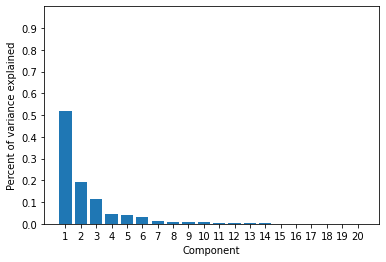

In [0]:
import matplotlib.pyplot as plt
import numpy as np

plt.bar(range(1, 21), pca.explained_variance_ratio_) 
plt.xlabel('Component') 
plt.xticks(range(1, 21))
plt.ylabel('Percent of variance explained')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1, step=0.1))
plt.show()

As you can see, the initial few components capture the majority of the variance in our 20 original features.

To see just how much, it can be helpful to plot this as the cumulative sum of variance explained.

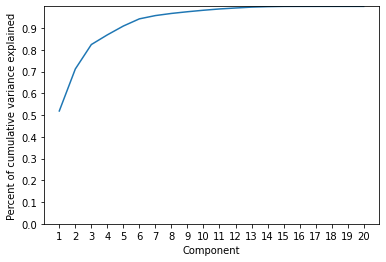

In [0]:
plt.plot(range(1, 21), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Component') 
plt.xticks(range(1, 21))
plt.ylabel('Percent of cumulative variance explained')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1, step=0.1))
plt.show()

We can now easily see that the first three components account for over 80 percent of the variation in our data.

Through the rest of this lesson, we'll look at how we can use the results of our PCA process on real-world data science projects.

-sandbox
&copy; 2020 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="http://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="http://help.databricks.com/">Support</a>